In [72]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader.data as web
from datetime import datetime, date
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.preprocessing import minmax_scale
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM
import keras.backend as K
from keras.optimizers import Adam
import keras
import h5py as h5py
import cython
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [73]:
import os
os.getcwd()
os.chdir('D:\Stanford\CS230\Project')
os.getcwd()

'D:\\Stanford\\CS230\\Project'

In [74]:
usgg10_data = pd.read_csv('USGG10TS.csv')

In [75]:
usgg10_data.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Change %'], dtype='object')

In [76]:
raw_data = usgg10_data.dropna()
#Convert to scales between 0 and 1
raw_data.date = pd.to_datetime(raw_data.Date)
raw_data_inx = raw_data.set_index(["Date"], drop=True)


C:\Users\owen1\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


In [77]:
#Convert prices in basis points
price = raw_data_inx[['Price']]*100

In [78]:
#Convert the dataseries to datetime to facilitate splitting into training and testing data
price.index = pd.to_datetime(price.index)

In [79]:
#The training data is from beginning to 1/1/2016, and the test data is everything onwards
splitdate = pd.Timestamp('1-Jan-16')
train_data = price.loc[:splitdate]
test_data = price.loc[splitdate:]

In [80]:
#Apply the min/max scale
train_data_scaled = train_data.apply(minmax_scale)
test_data_scaled = test_data.apply(minmax_scale)

In [81]:
X_train = train_data_scaled[:-1]
y_train = train_data_scaled[1:]

X_test = test_data_scaled[:-1]
y_test = test_data_scaled[1:]

In [82]:
X_train_lstm = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

In [83]:
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(12, input_shape=(1, X_train.shape[1]), activation='relu', 
                    kernel_initializer='lecun_uniform', return_sequences=False))

model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_train_lstm, y_train, epochs=200, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

y_pred_test_lstm = model_lstm.predict(X_test_lstm)
y_train_pred_lstm = model_lstm.predict(X_train_lstm)

Epoch 1/200
6756/6756 [==============================] - 14s 2ms/step - loss: 0.0186
Epoch 2/200
6756/6756 [==============================] - 13s 2ms/step - loss: 5.2779e-04
Epoch 3/200
6756/6756 [==============================] - 14s 2ms/step - loss: 2.9875e-04
Epoch 4/200
6756/6756 [==============================] - 13s 2ms/step - loss: 2.3347e-04
Epoch 5/200
6756/6756 [==============================] - 13s 2ms/step - loss: 2.0404e-04
Epoch 6/200
6756/6756 [==============================] - 13s 2ms/step - loss: 1.9291e-04
Epoch 7/200
6756/6756 [==============================] - 13s 2ms/step - loss: 1.8643e-04
Epoch 8/200
6756/6756 [==============================] - 13s 2ms/step - loss: 1.8167e-04
Epoch 9/200
6756/6756 [==============================] - 13s 2ms/step - loss: 1.7785e-04
Epoch 10/200
6756/6756 [==============================] - 13s 2ms/step - loss: 1.7463e-04
Epoch 11/200
6756/6756 [==============================] - 13s 2ms/step - loss: 1.7171e-04
Epoch 12/200
6756/6756 

In [93]:
model_lstm.save('USGG_LSTM.h5')

In [85]:
model_lstm = load_model('USGG_LSTM.h5')

In [88]:
y_pred_test_LSTM = model_lstm.predict(X_test_lstm)

In [90]:
y_test_reset = y_test.reset_index()
y_true = y_test.to_numpy()

In [91]:
col1 = pd.DataFrame(y_true, columns=['True'])
col2 = pd.DataFrame(y_pred_test_LSTM, columns=['LSTM_prediction'])
results = pd.concat([col1, col2], axis=1)

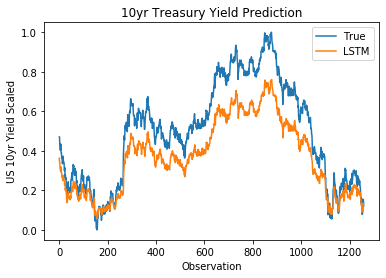

In [96]:
plt.plot(results['True'], label='True')
plt.plot(results['LSTM_prediction'], label='LSTM')
plt.title("10yr Treasury Yield Prediction")
plt.xlabel('Observation')
plt.ylabel('US 10yr Yield Scaled')
plt.legend()
plt.show()